In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_squared_error, root_mean_squared_error

In [2]:
# Load the dataset
file_path = '/Users/anjanhk/Downloads/Cotton Project/IMDb Movies India.csv'  
movie_data = pd.read_csv(file_path, encoding='ISO-8859-1')

In [4]:
movie_data.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [5]:
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [6]:
movie_data.describe()

,Rating
count,7919.000000
mean,5.841621
std,1.381777
min,1.100000
25%,4.900000
50%,6.000000
75%,6.800000
max,10.000000


In [10]:
movie_data.dtypes

Name         object
Year         object
Duration     object
Genre        object
Rating      float64
Votes        object
Director     object
Actor 1      object
Actor 2      object
Actor 3      object
dtype: object

In [12]:
movie_data.shape

(15509, 10)

In [14]:
movie_data.isna().sum()

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

In [15]:
movie_data.dropna(subset=['Rating'], inplace=True)
movie_data.isna().sum()

Name           0
Year           0
Duration    2068
Genre        102
Rating         0
Votes          0
Director       5
Actor 1      125
Actor 2      200
Actor 3      292
dtype: int64

In [19]:
movie_data['Genre'] = movie_data['Genre'].fillna('Unknown')
movie_data.isna().sum()

Name           0
Year           0
Duration    2068
Genre          0
Rating         0
Votes          0
Director       5
Actor 1      125
Actor 2      200
Actor 3      292
dtype: int64

In [20]:
# Data cleaning
movie_data_cleaned = movie_data.dropna(subset=['Rating']).copy()

In [21]:
# Clean and convert Votes column
movie_data_cleaned['Votes'] = movie_data_cleaned['Votes'].str.replace(',', '').astype(float, errors='ignore')

In [22]:
# Extract numeric Year and drop rows where both Votes and Year are missing
movie_data_cleaned['Year'] = movie_data_cleaned['Year'].str.extract(r'(\d{4})').astype(float, errors='ignore')
movie_data_cleaned = movie_data_cleaned.dropna(subset=['Votes', 'Year'], how='all')

In [23]:
# Fill missing values in categorical columns and clean Genre
categorical_columns = ['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']
for col in categorical_columns:
    movie_data_cleaned[col] = movie_data_cleaned[col].fillna('Unknown')

movie_data_cleaned['Genre'] = movie_data_cleaned['Genre'].apply(lambda x: x.split(',')[0] if isinstance(x, str) and ',' in x else x)

In [24]:
# Sanity check
print("Data after cleaning:")
print(movie_data_cleaned[categorical_columns].head())
print(f"Remaining rows: {movie_data_cleaned.shape[0]}")

if movie_data_cleaned[categorical_columns].shape[0] == 0:
    raise ValueError("Categorical data is empty. Please check preprocessing steps.")

Data after cleaning:
    Genre        Director          Actor 1                 Actor 2  \
1   Drama   Gaurav Bakshi     Rasika Dugal          Vivek Ghamande   
3  Comedy      Ovais Khan          Prateik              Ishita Raj   
5  Comedy    Rahul Rawail       Bobby Deol  Aishwarya Rai Bachchan   
6   Drama  Shoojit Sircar  Jimmy Sheirgill          Minissha Lamba   
8  Horror   Allyson Patel        Yash Dave          Muntazir Ahmad   

           Actor 3  
1    Arvind Jangid  
3  Siddhant Kapoor  
5    Shammi Kapoor  
6   Yashpal Sharma  
8     Kiran Bhatia  
Remaining rows: 7919


In [25]:
# Feature selection
features = ['Genre', 'Year', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']
target = 'Rating'

In [26]:
# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = encoder.fit_transform(movie_data_cleaned[['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']])

In [27]:
# Combine encoded categorical features with numeric ones
numeric_features = movie_data_cleaned[['Year', 'Votes']].values
X = pd.concat([pd.DataFrame(encoded_features), pd.DataFrame(numeric_features)], axis=1)
y = movie_data_cleaned[target].values

In [28]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Train a Random Forest Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [32]:
# Predict and evaluate the model
y_pred = model.predict(X_test)

In [33]:
# Calculate RMSE using root_mean_squared_error
rmse = root_mean_squared_error(y_test, y_pred) 

r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

Root Mean Squared Error (RMSE): 1.0980284593191323
R^2 Score: 0.3514941512000195


In [58]:
# Predict the ratings for the test set
y_pred = model.predict(X_test)

# Print the first 10 predicted ratings
print("Predicted Ratings for the Test Set:")
print(y_pred[:15])

Predicted Ratings for the Test Set:
[3.949 5.108 6.264 4.23  5.825 5.966 5.746 7.324 5.721 5.604 5.911 7.244
 5.523 5.147 5.4  ]


In [57]:
# Predict the ratings for the training set
y_train_pred = model.predict(X_train)

# Print the first 10 predicted ratings for the training set
print("Predicted Ratings for the Training Set:")
print(y_train_pred[:15])

Predicted Ratings for the Training Set:
[7.926 6.044 4.695 5.388 7.934 5.19  5.243 4.98  5.444 5.686 8.068 5.083
 4.685 4.708 5.946]


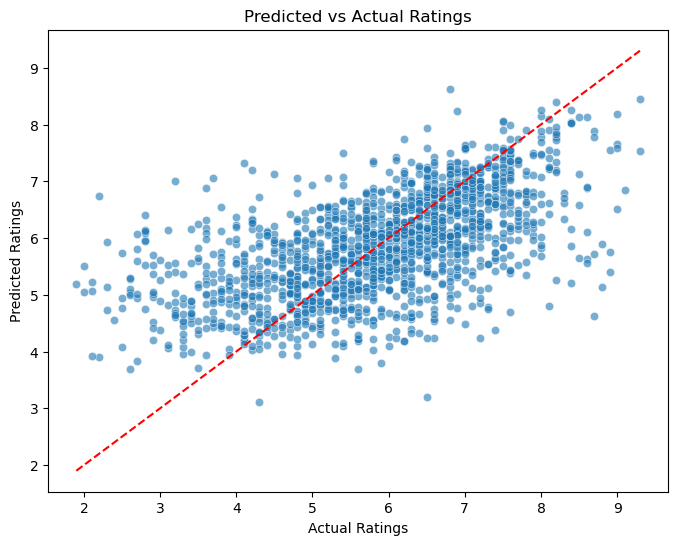

In [34]:
# Plot predicted vs actual ratings
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Predicted vs Actual Ratings")
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.show()

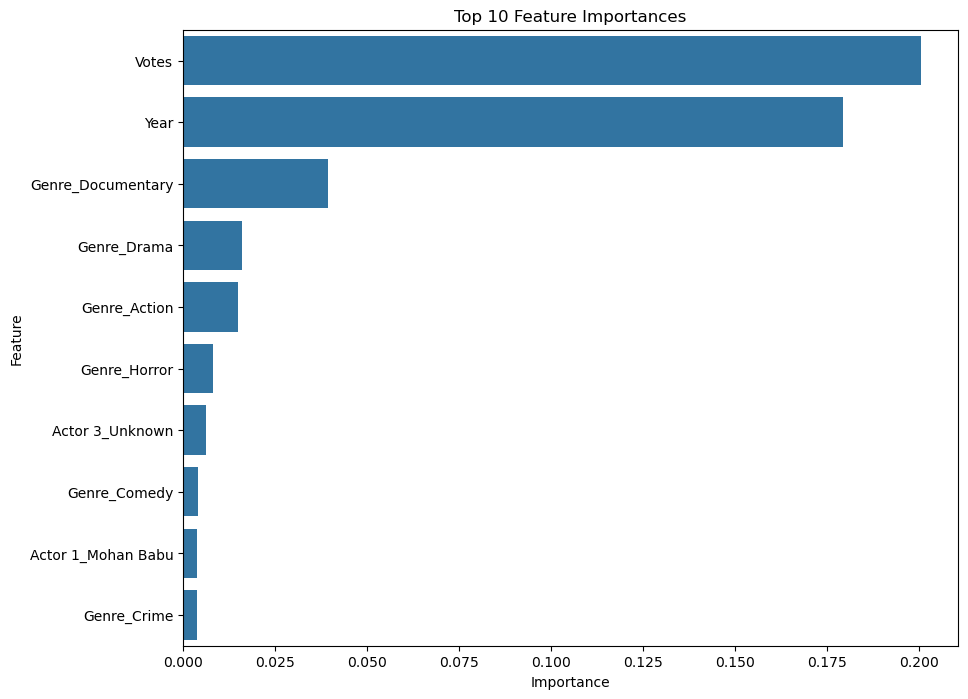

In [35]:
# Feature importance plot
if hasattr(model, "feature_importances_"):
    feature_importances = model.feature_importances_
    feature_names = list(encoder.get_feature_names_out(['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']))
    feature_names += ['Year', 'Votes']
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x="Importance", y="Feature", data=importance_df.head(10))
    plt.title("Top 10 Feature Importances")
    plt.show()

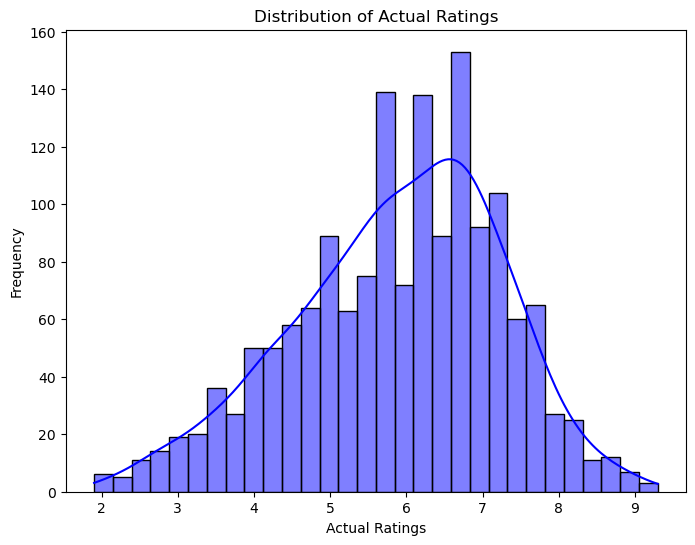

In [36]:
plt.figure(figsize=(8, 6))
sns.histplot(y_test, kde=True, color='blue', bins=30)
plt.title("Distribution of Actual Ratings")
plt.xlabel("Actual Ratings")
plt.ylabel("Frequency")
plt.show()

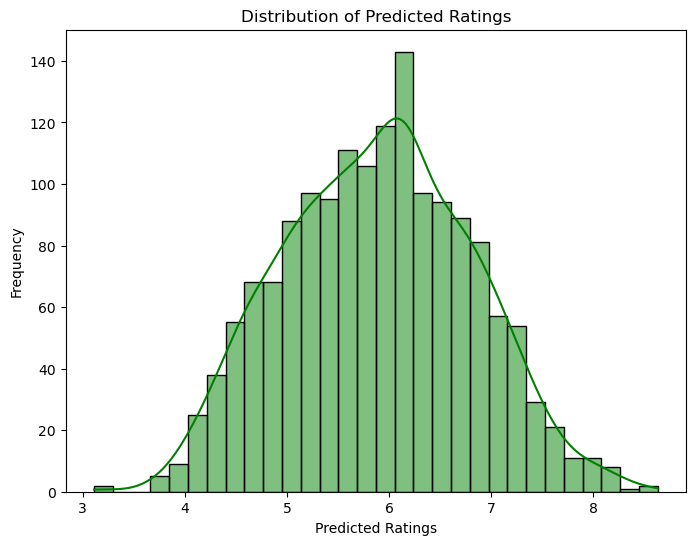

In [37]:
plt.figure(figsize=(8, 6))
sns.histplot(y_pred, kde=True, color='green', bins=30)
plt.title("Distribution of Predicted Ratings")
plt.xlabel("Predicted Ratings")
plt.ylabel("Frequency")
plt.show()

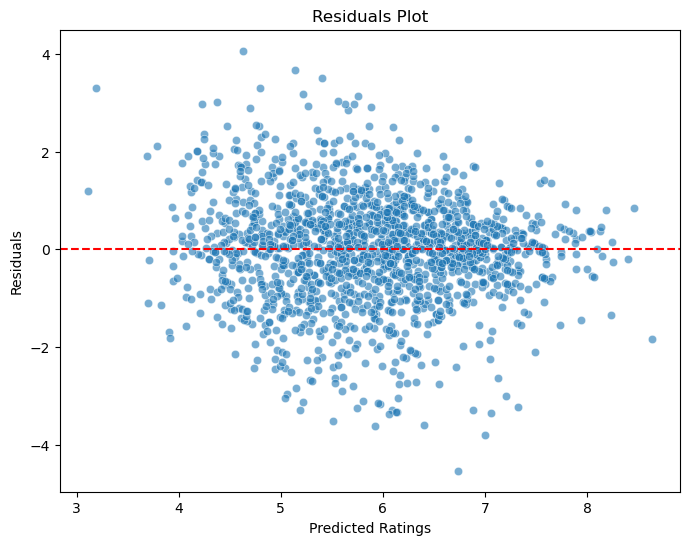

In [38]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals Plot")
plt.xlabel("Predicted Ratings")
plt.ylabel("Residuals")
plt.show()


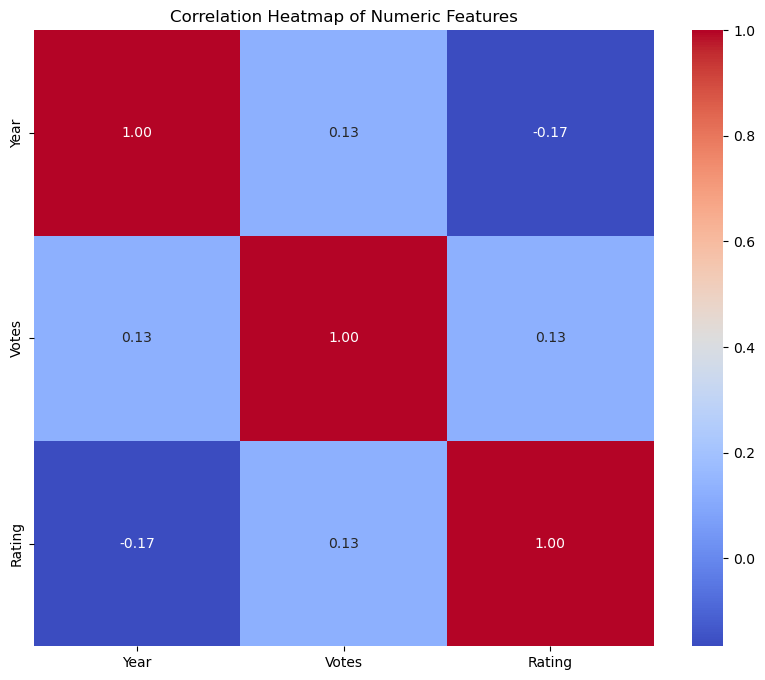

In [39]:
plt.figure(figsize=(10, 8))
corr_matrix = movie_data_cleaned[['Year', 'Votes', 'Rating']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


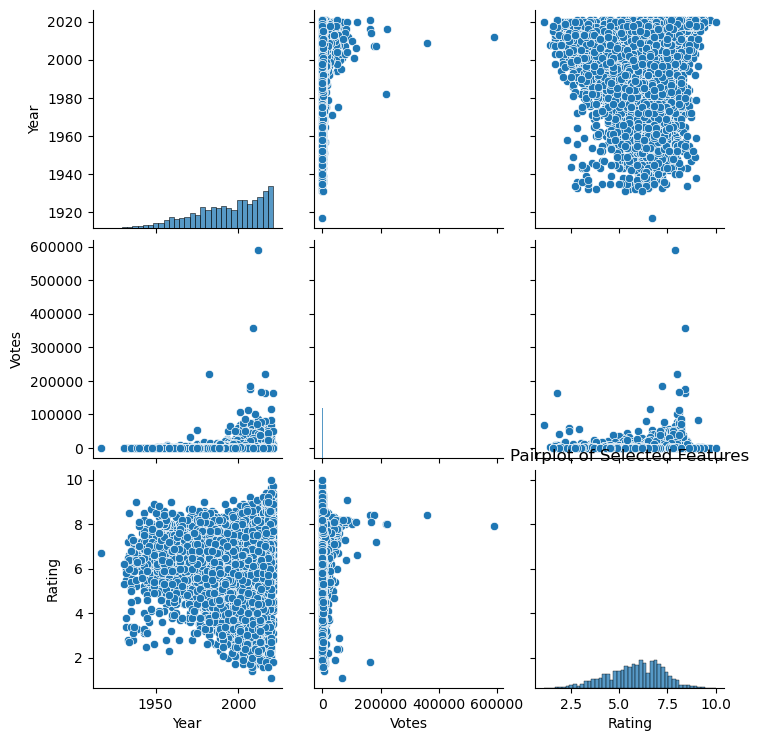

In [40]:
sns.pairplot(movie_data_cleaned[['Year', 'Votes', 'Rating']])
plt.title("Pairplot of Selected Features")
plt.show()

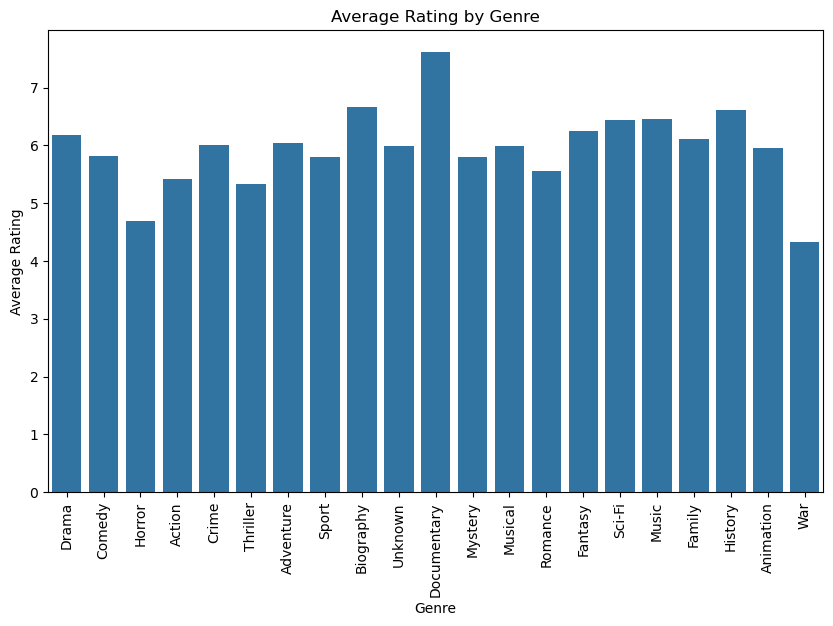

In [46]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Genre', y='Rating', data=movie_data_cleaned, errorbar=None)
plt.xticks(rotation=90)
plt.title("Average Rating by Genre")
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.show()

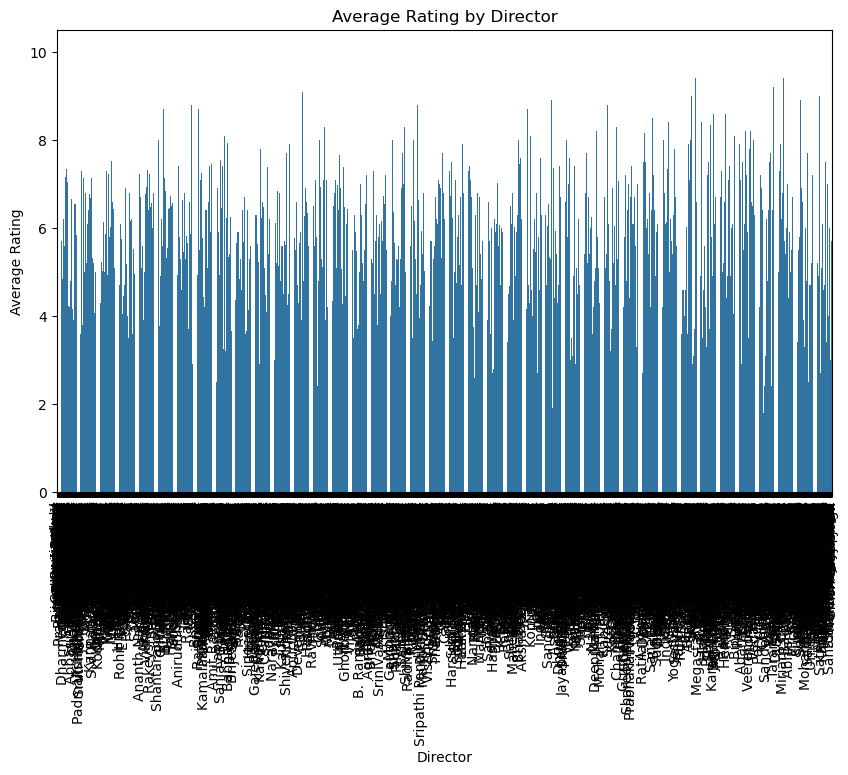

In [44]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Director', y='Rating', data=movie_data_cleaned, errorbar=None)
plt.xticks(rotation=90)
plt.title("Average Rating by Director")
plt.xlabel("Director")
plt.ylabel("Average Rating")
plt.show()